#  Gym environment with scikit-decide tutorial: Continuous Mountain Car

In this notebook we will solve the continuous mountain car problem taken from [OpenAI Gym](https://gym.openai.com/), a toolkit for developing environments, usually to be solved by reinforcement learning algorithms.
Continuous Mountain Car, a standard testing domain in Reinforcement Learning (RL), is a problem in which an under-powered car must drive up a steep hill. Note that we use here the *continuous* version of the mountain car because 
it has a shaped reward (i.e.not sparse) which can be used successfully when solving, as opposed to the other "Mountain Car" environments. 

***Citation needed about what is a shaped/sparse reward***


<div align="middle">
    <video controls autoplay preload 
         src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/original.mp4">
    </video>
</div>


This problem has been chosen for three reasons:
  - Show how scikit-decide can be used to solve Gym environments (the de-facto standard in the RL community),
  - Highlight that by doing so, you will be able to use not only solvers from the RL community (like the ones in [stable_baselines3](https://github.com/DLR-RM/stable-baselines3) for example), but also other solvers coming from other communities like genetic programming and planning/search (use of an underlying search graph) that can sometimes be very efficient.

Therefore in this notebook we will go through the following steps:
  - Wrap a Gym environment in a scikit-decide domain;
  - Use a classical RL algorithm like PPO to solve our problem;
  - Give CGP (Cartesian Genetic Programming)  a try on the same problem;
  - Finally use IW (Iterated Width) coming from the planning community on the same problem.

In [1]:
# choose standard matplolib inline backend to render plots
%matplotlib inline

In [2]:
from enum import Enum
from typing import NamedTuple, Optional, Any, List, Callable
from copy import deepcopy
from time import sleep
from collections import deque
import random
from math import sqrt, ceil
from base64 import b64encode
import glob
import os

from IPython.display import HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import gym

from skdecide.hub.solver.stable_baselines import StableBaseline
from skdecide import DeterministicPlanningDomain, Space, Value, Solver
from skdecide.hub.domain.gym import (
    GymDomain,
    GymWidthDomain,
    GymDiscreteActionDomain,
    GymPlanningDomain,
)
from skdecide.builders.domain import UnrestrictedActions, Renderable
from skdecide.hub.space.gym import ListSpace, EnumSpace, MultiDiscreteSpace
from skdecide.hub.solver.iw import IW
from skdecide.hub.solver.cgp import CGP  # Cartesian Genetic Programming



When running this notebook on remote servers like with Colab or Binder, rendering of gym environment will fail as no actual display device exists. Thus we need to start a virtual display to make it work.

In [3]:
if "DISPLAY" not in os.environ:
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
    _display.start()

## About Continuous Mountain Car problem

The agent (a car) is started at the bottom of a valley. For any given
state the agent may choose to accelerate to the left, right or cease
any acceleration.

### Observations

- Car Position  [-1.2, 0.6]
- Car Velocity  [-0.07, +0.07]

### Action
- the power coefficient [-1.0, 1.0]


### Goal
The car position is more than 0.45.

### Reward

Reward of 100 is awarded if the agent reached the flag (position = 0.45) on top of the mountain.
Reward is decrease based on amount of energy consumed each step.

### Starting State
The position of the car is assigned a uniform random value in [-0.6 , -0.4].
The starting velocity of the car is always assigned to 0.

         

## Wrap Gym environment in a scikit-decide domain

We choose the gym environment we would like to use.

In [4]:
ENV_NAME = "MountainCarContinuous-v0"

We define a domain factory using `GymDomain` proxy available in scikit-decide which will wrap the Gym environment, for solving purpose.

In [5]:
domain_factory = lambda: GymDomain(gym.make(ENV_NAME))

We also define another domain factory using an intermediate wrapper `gym.wrapper.Monitor` able to record movies, for rolling-out purpose.

In [6]:
domain4movie_factory = lambda: GymDomain(
    gym.wrappers.Monitor(gym.make(ENV_NAME), "tmp_gym_recording", force=True)
)

Here is a screenshot of such an environment. 

Note: We close the domain straight away to avoid leaving the OpenGL pop-up window open on local Jupyter sessions.

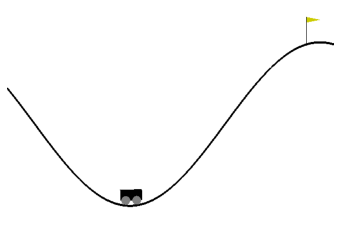

In [7]:
domain = domain_factory()
domain.reset()
plt.imshow(domain.render(mode="rgb_array"))
plt.axis("off")
domain.close()

## Solve  with Reinforcement Learning (StableBaseline + PPO)

We first try a solver coming from the Reinforcement Learning community that is make use of OpenAI [stable_baselines3](https://github.com/DLR-RM/stable-baselines3), which give access to a lot of RL algorithms.

Here we choose Proximal Policy Optimization (PPO) solver. It alternates between sampling data through interaction with the environment, and optimizing a "surrogate" objective function using stochastic gradient ascent.

***Reference to a paper needed. Perhaps more details also.***

### Check compatibility
We check the compatibility of the domain with the chosen solver.

In [7]:
domain = domain_factory()
assert StableBaseline.check_domain(domain)
domain.close()

### Solver instantiation

In [8]:
solver = StableBaseline(
    PPO, "MlpPolicy", learn_config={"total_timesteps": 50000}, verbose=True
)

### Training solver on domain
The solver will try to find an appropriate policy to solve the maze. 

In [9]:
GymDomain.solve_with(solver, domain_factory)

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 1442 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1056         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036787898 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -0.118       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0113      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00695     |
|    std                  | 0.934        |
|    value_loss           | 0.0758       

-----------------------------------------
| time/                   |             |
|    fps                  | 828         |
|    iterations           | 12          |
|    time_elapsed         | 29          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.005213792 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.704      |
|    explained_variance   | -0.0217     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00321     |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00597    |
|    std                  | 0.476       |
|    value_loss           | 0.0655      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 827          |
|    iterations           | 13           |
|    time_elapsed         | 32

------------------------------------------
| time/                   |              |
|    fps                  | 801          |
|    iterations           | 23           |
|    time_elapsed         | 58           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0077371337 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0469      |
|    explained_variance   | 0.0272       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00268     |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00533     |
|    std                  | 0.247        |
|    value_loss           | 0.0116       |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 800          |
|    iterations           | 24           |
|    time_e

### Rolling out a solution

We can use the trained solver to roll out an episode to see if this is actually solving the problem at hand.

For educative purpose, we define here our own rollout (which will probably be needed if you want to actually use the solver in a real case). If you want to take a look at the (more complex) one already implemented in the library, see [utils.py](https://github.com/airbus/scikit-decide/blob/master/skdecide/utils.py) module.


In [8]:
def rollout(
    domain: GymDomain,
    solver: Solver,
    max_steps: int,
    pause_between_steps: Optional[float] = 0.01,
):
    """Roll out one episode in a domain according to the policy of a trained solver.

    Args:
        domain: the maze domain to solve
        solver: a trained solver
        max_steps: maximum number of steps allowed to reach the goal
        pause_between_steps: time (s) paused between agent movements.
          No pause if None.

    """
    # Initialize episode
    solver.reset()
    observation = domain.reset()

    # Initialize image
    plt.ioff()
    fig, ax = plt.subplots(1)
    ax.axis("off")
    plt.ion()
    img = ax.imshow(domain.render(mode="rgb_array"))
    display(fig)

    # loop until max_steps or goal is reached
    for i_step in range(1, max_steps + 1):
        if pause_between_steps is not None:
            sleep(pause_between_steps)

        # choose action according to solver
        action = solver.sample_action(observation)
        # get corresponding action
        outcome = domain.step(action)
        observation = outcome.observation

        # update image
        img.set_data(domain.render(mode="rgb_array"))
        fig.canvas.draw()
        clear_output(wait=True)
        display(fig)

        # final state reached?
        if outcome.termination:
            break

    # goal reached?
    is_goal_reached = outcome.termination
    if is_goal_reached:
        print(f"Goal reached in {i_step} steps!")
    else:
        print(f"Goal not reached after {i_step} steps!")

    return is_goal_reached, i_step

We create a domain for the roll out and close it at the end. If not closing it, an OpenGL popup windows stays open, at least on local Jupyter sessions.

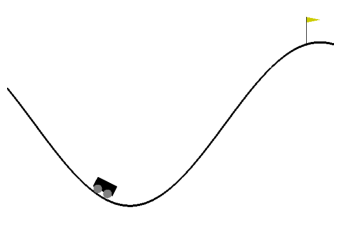

Goal not reached after 999 steps!


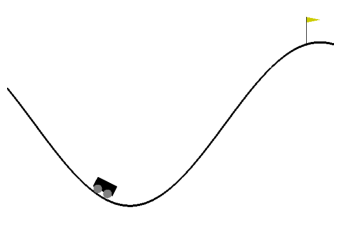

In [11]:
domain = domain_factory()
try:
    rollout(domain=domain, solver=solver, max_steps=1000, pause_between_steps=None)
finally:
    domain.close()

Policy-gradient RL algorithms like PPO are well-fitted to continuous domains with non-sparse rewards like in this continuous  version of Mountain Car where the reward is already shaped in the domain (instead of a single reward when reaching the goal).

### Cleaning up

Some solvers need proper cleaning before being deleted.

In [12]:
solver._cleanup()

Note that this is automatically done if you use the solver within a `with` statement. The syntax would look something like:

```python
with solver_factory() as solver:
    MyDomain.solve_with(solver, domain_factory)
    rollout(domain=domain, solver=solver
```

## Solve with Cartesian Genetic Programming (CGP)

CGP (Cartesian Genetic Programming) is a form of genetic programming that uses a graph representation (2D grid of nodes) to encode computer programs.

Pros:
+ ability to customize the set of atomic functions used by CPG (e.g. to inject some domain knowledge)
+ ability to inspect the final formula found by CGP (no black box)

Cons:
- the fitness function of CGP is defined by the rewards, so can be unable to solve in sparse reward scenarios

### Check compatibility
We check the compatibility of the domain with the chosen solver.

In [13]:
domain = domain_factory()
assert CGP.check_domain(domain)
domain.close()

[Box(-1.0, 1.0, (1,), float32)]
[Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)]


### Solver instantiation

In [14]:
solver = CGP("TEMP_CGP", n_it=25, verbose=True)

### Training solver on domain
The solver will try to find an appropriate policy to solve the maze. 

In [15]:
GymDomain.solve_with(solver, domain_factory)

[ 9  0  0  9  2  2 17  1  1  5  0  0 17  0  4  3  0  5 14  0  6  8  2  1
  4  9  9 11  0  3  5 10  7  9  6 12  2 11  9 12  8  4 14 11  3  8 12 16
  8 14  7 15  5 12  5 16 18 19 16 15 20  0  7  9  3 16 10  6 22  5 20  8
  4 21 13  7 10  6 14 10 27  7  1 21 19 29  8  2 29  2 20 30 11 20  8 21
 10  2 32 12  4 20  4  5 12  8 14 18  9 20  9  5 15  6  6 28 33  9 32 15
  0 32  3 18  4 35 10  4 38 20 14 36  1 20 18  2  2 26  6 37  9  3  7 33
 14 40 25 13 31 23  2 36 32  1 45 28  8 20 38 16 38 37  0 15 12 14 21 56
 11 28 14 18 44 32  4 56 40 12 20  2 13  1 48  6 47 23  7 16  9 14 38 64
 10 53 14 11 29  5  3 59 22  6 60 22  3 35 67 19 27 57 14 36 44 15 60 69
  4 61 49  0 65  1 10 32 52  5 45 39  4  7 43 20 15 20 17 38 35 20 28 23
 15 22 41  0 60  6 15 77  1 19 21 28 16 41  8 11 61 27  0 24  3  5 56 40
 19 34 71 20 36 57  3 44 82 20 76 57  4 61 71 19 13 58 13 66 79  5 90 34
  7 48 66 15 19 76  9 62  9 19 23 13 73]
1 	 0.0 	 True 	 [-99.43484948   0.          -0.1        -99.6       ]
2 	 0.0 	 Tr

### Rolling out a solution

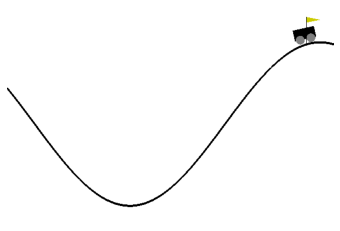

Goal reached in 124 steps!


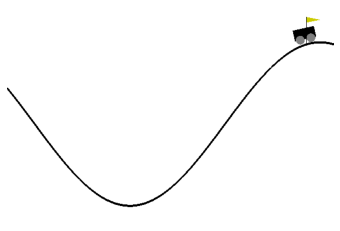

In [16]:
domain = domain_factory()
try:
    rollout(domain=domain, solver=solver, max_steps=1000, pause_between_steps=None)
finally:
    domain.close()

CGP is doing well on this problem!

***More insight ?***

### Cleaning up

In [12]:
solver._cleanup()

## Solve with Classical Planning  (IW)

Iterated Width (IW) is a width based search algorithm that builds a graph on-demand, while pruning non-novel nodes. 

In order to handle continuous domains, a state encoding specific to continuous state variables dynamically and adaptively discretizes the continuous state variables in such a way to build a compact graph based on intervals (rather than a naive grid of discrete point values). 

The novelty measures discards intervals that are included in previously explored intervals, thus favoring to extend the state variable intervals. 

It works especially well in mountain car because we need to increase the cinetic+potential energy to reach the goal, which comes to increase as much as possible the values of the state variables. IW can find an optimal strategy in a few seconds (in most cases PPO and CGP can't find optimal strategies in the same computation time).

### Prepare the domain for IW

We need to wrap the Gym environment in a domain with finer charateristics so that IW can be used on it.

***Perhaps more explanation about what we are doing here and why it is required ?***

In [9]:
class D(GymPlanningDomain, GymWidthDomain, GymDiscreteActionDomain):
    pass


class GymDomainForWidthSolvers(D):
    def __init__(
        self,
        gym_env: gym.Env,
        set_state: Callable[[gym.Env, D.T_memory[D.T_state]], None] = None,
        get_state: Callable[[gym.Env], D.T_memory[D.T_state]] = None,
        termination_is_goal: bool = True,
        continuous_feature_fidelity: int = 5,
        discretization_factor: int = 3,
        branching_factor: int = None,
        max_depth: int = 1000,
    ) -> None:
        GymPlanningDomain.__init__(
            self,
            gym_env=gym_env,
            set_state=set_state,
            get_state=get_state,
            termination_is_goal=termination_is_goal,
            max_depth=max_depth,
        )
        GymDiscreteActionDomain.__init__(
            self,
            discretization_factor=discretization_factor,
            branching_factor=branching_factor,
        )
        GymWidthDomain.__init__(
            self, continuous_feature_fidelity=continuous_feature_fidelity
        )
        gym_env._max_episode_steps = max_depth

    def state_features(self, s):
        return self.bee2_features(s)

    def heuristic(self, s):
        return Value(cost=0)

We redefine accordingly the domain factory.

In [10]:
domain4width_factory = lambda: GymDomainForWidthSolvers(gym.make(ENV_NAME))

### Check compatibility
We check the compatibility of the domain with the chosen solver.

In [11]:
domain = domain4width_factory()
assert IW.check_domain(domain)
domain.close()

### Solver instantiation

In [12]:
solver = IW(
    state_features=lambda d, s: d.bee2_features(s),
    node_ordering=lambda a_gscore, a_novelty, a_depth, b_gscore, b_novelty, b_depth: a_novelty
    > b_novelty,
    parallel=False,
    debug_logs=False,
    domain_factory=domain4width_factory,
)

### Training solver on domain
The solver will try to find an appropriate policy to solve the maze. 

In [13]:
GymDomainForWidthSolvers.solve_with(solver, domain4width_factory)

### Rolling out a solution

**Disclaimer:** This roll out can be a bit painful to look on local Jupyter sessions. Indeed, IW creates copies of the environment at each step which makes pop up then close a new OpenGL window each time.

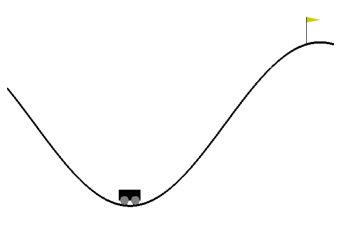

Goal not reached after 3 steps!


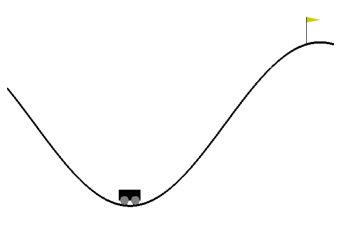

In [15]:
domain = domain4width_factory()
try:
    rollout(domain=domain, solver=solver, max_steps=1000, pause_between_steps=None)
finally:
    domain.close()

### Cleaning up

In [12]:
solver._cleanup()

## Conclusion

We saw that it is possible thanks to scikit-decide to apply solvers from different fields and communities (Reinforcement Learning, Genetic Programming, and Planning) on a OpenAI Gym Environment.

Even though the domain used here is more classical for RL community, the solvers from other communities performed very well. In particular the IW algorithm was able to find an efficient solution in less than 1 second.